---

<img src='../../../common/logo_DH.png' align='left' width=35%/>


## CheckPoint GeoPandas

## Datasets

En la práctica de la clase de hoy usaremos un **conjunto de propiedades** que tienen a la venta la inmobiliaria Properati: https://www.properati.com.ar/. Lo interesante es que a los datos clásicos de la propiedad (valor, superficie, barrio, tipo de propiedad), le agrega la posición geoespacial mediante su latitud y longitud.

Por otra parte, vamos a considerar a las **estaciones de subte**, donde tambien figuran el nombre y la línea a la que pertenece, y además, obviamente, sus datos geoposicionales.

## Ejercicio

Comenzamos leyendo los dos datasets en un *dataframe*, y lo transformamos en un *GeoDataFrame*. Es el tipo de datos que requiere GeoPandas para realizar operaciones con datos geoespaciales.

Luego vamos a *calcular la distancia* de cada propiedad al obelisco de Buenos Aires, y se registrará en una nueva columna. Haremos un cálculo para ver si existe alguna relacion entre esta distancia y el precio de la propiedad.

Finalmente *trazaremos una línea geométrica* con todas las estaciones de subte de una línea, y la graficaremos sobre la ciudad.

Alla vamos!

---

Importamos las bibliotecas que vamos a necesitar:

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import shapely # genera las figuras geometricas
import descartes # relaciona shapely con matplotlib
import pyproj # proyecciones. Transformar coordenadas

---

### Parte 1 - Archivo de propiedades

Vamos a leer los datos del archivo /M1/CLASE_07/Data/properati_caba.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_prop. 

*Nota:* los datos vienen separados por tabs. Se debe usar el parámetro <code>sep='\t'</code>

Ayuda:
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [2]:
df_prop = pd.read_csv('../Data/properati_caba.csv', sep='\t')

#### Tomamos una muestra de 5 elementos

Las columnas del dataset son:

- property_type. Tipo de propiedad. Categórico.
- place_name. Barrio de Buenos Aires. Categórico.
- country_name. Pais. Fijo 'Argentina'.
- state_name. Provincia. Fijo 'Capital Federal'.
- lat. Latitud de la posición geoespacial del inmueble.
- lon. Longitud de la posición geoespacial del inmueble.
- price. Valor de la propiedad.
- currency. Moneda usada para el valor de la propiedad.
- surface_total_in_m2. Area del inmueble.

In [3]:
df_prop.head()

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0


#### Transformar el DataFrame en un GeoDataFrame

Para generar un GeoDataFrame, necesitamos agregar a las columnas del DataFrame una nueva columna que contenga una forma geométrica. Es este caso, un *punto*, el cual se genera a partir de la *latitud* y la *longitud*.

Es recomendable que la nueva columna se llame *geometry*.

El método `gpd.points_from_xy` define el tipo *punto*, ingresando primero la **longitud** y luego la **latitud**.

Ayuda:
https://geopandas.org/reference/geopandas.points_from_xy.html

In [4]:
geometria = gpd.points_from_xy(df_prop['lon'],df_prop['lat'])  #df_prop.lon

In [5]:
geometria[0:2]

<GeometryArray>
[<shapely.geometry.point.Point object at 0x0000023263F9B2C8>, <shapely.geometry.point.Point object at 0x00000232639698C8>]
Length: 2, dtype: geometry

In [6]:
geo_prop = gpd.GeoDataFrame(df_prop, geometry=geometria)

In [7]:
type(geo_prop)

geopandas.geodataframe.GeoDataFrame

In [8]:
geo_prop.loc[:4, ['geometry', 'lat', 'lon','property_type','place_name']]

,geometry,lat,lon,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


---

### Parte 2 - Archivo de estaciones de subte

Vamos a leer los datos del archivo /M1/CLASE_07/Data/estaciones-de-subte.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_subte.

*Nota:* los datos vienen separados por comas. Se debe usar el parámetro <code>sep=','</code>

In [38]:
location='../Data/estaciones-de-subte.csv'
df_subtes = pd.read_csv(location)

#### Consultamos los primeros 10 registros

Las columnas del dataset son:

- long. Longitud de la posición geoespacial de la estación de subte.
- lat. Latitud de la posición geoespacial de la estación de subte.
- id. Número secuencial.
- estacion. Nombre de la estación de subte.
- linea. Línea de subte a la que pertenece la estación. Categórico.

In [39]:
df_subtes.head(10)

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H
5,-58.380574,-34.604245,6.0,9 DE JULIO,D
6,-58.397924,-34.599757,7.0,FACULTAD DE MEDICINA,D
7,-58.385142,-34.601587,8.0,TRIBUNALES - TEATRO COLÓN,D
8,-58.407161,-34.591628,9.0,AGÜERO,D
9,-58.415955,-34.585156,10.0,R.SCALABRINI ORTIZ,D


#### Transformar el DataFrame en un GeoDataFrame

Para generar un GeoDataFrame, necesitamos agregar a las columnas del DataFrame una nueva columna que contenga una forma geométrica. Es este caso, un *punto*, el cual se genera a partir de la *latitud* y la *longitud*.

Es recomendable que la nueva columna se llame *geometry*.

El método `gpd.points_from_xy` define el tipo *punto*, ingresando primero la **longitud** y luego la **latitud**.

In [40]:
geometria_subtes = gpd.points_from_xy(df_subtes['long'], df_subtes['lat'])

In [41]:
type(geometria_subtes)

geopandas.array.GeometryArray

In [44]:
geo_subte = gpd.GeoDataFrame(df_subtes, geometry=geometria_subtes)

---

### Parte 3 - Cálculo de la distancia

Vamos a calcular la **distancia de cada propiedad al obelisco de Buenos Aires**, y la registramos en una nueva columna.

Primero necesitamos representar el lugar geográfico del Obelisco de Buenos Aires. Lo hacemos mediante la forma geométrica *Punto*, y las coordenadas del lugar. 

In [18]:
from shapely.geometry import Point

punto_obelisco_p = Point(-58.381555,-34.605425)

In [19]:
type(punto_obelisco_p)

shapely.geometry.point.Point

Pero el método que calcula la distancia entre dos puntos, <code>geopy.distance.geodesic</code>, necesita representar el lugar geográfico del Obelisco de Buenos Aires mediante una *tupla*.

In [20]:
punto_obelisco = (-58.381555,-34.605425)

In [21]:
type(punto_obelisco)

tuple

Ahora podemos agregar la nueva columna con la distancia entre el punto del obelisco y el punto de cada propiedad (en metros). La llamaremos *distancia_obelisco*. 

Se debe generar **una iteración** sobre el indice de geo_prop:

Ayuda:
<code>
for i in geo_prop.index:
    geo_prop.loc[i, 'distancia_obelisco'] = calculo distancia entre obelisco y cada propiedad.</code>
    
El cálculo se realiza con el método <code>geopy.distance.geodesic</code>, el cual se explica en la notebook 3_geopandas_operaciones.

Ademas con la sentencia <code>geo_prop.loc[i,'geometry'].x</code> obtenemos la coordenada longitud de la distancia.

Debe terminar con <code>.meters</code> para indicar la distancia en metros

Ver https://geopy.readthedocs.io/en/stable/#module-geopy.distance

In [27]:
import geopy.distance

for i in geo_prop.index:
    geo_prop.loc[i, 'distancia_obelisco'] = geopy.distance.geodesic(punto_obelisco, (geo_prop.loc[i,'geometry'].x,geo_prop.loc[i,'geometry'].y)).meters

In [28]:
geo_prop.loc[:4, ['distancia_obelisco','geometry', 'lat', 'lon','property_type','place_name']]

,distancia_obelisco,geometry,lat,lon,property_type,place_name
0,14555.078219,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,15988.570648,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,7381.316759,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,13651.907067,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos


Es interesante encontrar **valores extremos** en la distancia calculada (llamados *outliers*). Nos pueden distorsionar los calculos estadísticos.

Para ello vamos a ordenar el GeoDataFrame geo_prop por la columna *distancia_obelisco* en forma descendente. Y ver si en los primeros valores encontramos distancia que muestren un valor extremo respecto a los demás.

In [32]:
geo_prop.sort_values('distancia_obelisco', ascending=False).head()

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco
4202,apartment,Mataderos,Argentina,Capital Federal,-38.416097,-63.616672,45000.0,USD,70.0,POINT (-63.61667 -38.41610),618443.386395
3689,apartment,Belgrano,Argentina,Capital Federal,-34.578678,-58.544722,85000.0,USD,38.0,POINT (-58.54472 -34.57868),18241.418749
10749,apartment,Almagro,Argentina,Capital Federal,-34.558634,-58.542461,250000.0,USD,107.0,POINT (-58.54246 -34.55863),18129.491894
10557,apartment,Palermo,Argentina,Capital Federal,-34.558634,-58.542461,250000.0,USD,107.0,POINT (-58.54246 -34.55863),18129.491894
3808,apartment,Saavedra,Argentina,Capital Federal,-34.577168,-58.538654,931457.0,USD,38.0,POINT (-58.53865 -34.57717),17576.152416


El primer registro tiene una distancia incorrecta, que se genera a partir del dato erróneo de las coordenadas. Mejor eliminarlo.

Para ello, buscamos las propiedades que tienen una distancia_obelisco mayor a 19000 y las eliminamos:

- Buscamos los valores del índice que representan a esas propiedades: 

In [33]:
indice = geo_prop[geo_prop.distancia_obelisco > 19000].index

indice

Int64Index([4202], dtype='int64')

- Con el método drop eliminamos esas filas

<code>geo_prop.drop(              ,inplace=True)</code>

In [34]:
geo_prop.drop(indice, inplace=True)

Verificamos ordenando nuevamente por la distancia_obelisco en forma descendente.

In [35]:
geo_prop.sort_values('distancia_obelisco', ascending=False).head()

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,geometry,distancia_obelisco
3689,apartment,Belgrano,Argentina,Capital Federal,-34.578678,-58.544722,85000.0,USD,38.0,POINT (-58.54472 -34.57868),18241.418749
10557,apartment,Palermo,Argentina,Capital Federal,-34.558634,-58.542461,250000.0,USD,107.0,POINT (-58.54246 -34.55863),18129.491894
10749,apartment,Almagro,Argentina,Capital Federal,-34.558634,-58.542461,250000.0,USD,107.0,POINT (-58.54246 -34.55863),18129.491894
3789,apartment,Caballito,Argentina,Capital Federal,-34.577168,-58.538654,589700.0,USD,30.0,POINT (-58.53865 -34.57717),17576.152416
3734,apartment,Caballito,Argentina,Capital Federal,-34.577168,-58.538654,229000.0,USD,136.0,POINT (-58.53865 -34.57717),17576.152416


Y ahora podemos hacer un histograma sobre las distancias.

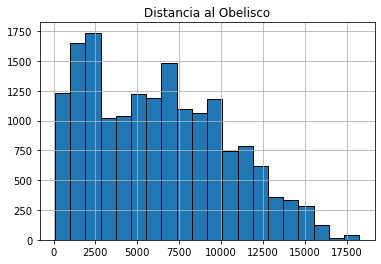

<Figure size 432x288 with 0 Axes>

In [36]:
plt.title('Distancia al Obelisco')
plt.hist(geo_prop["distancia_obelisco"], bins=20, alpha=1, edgecolor = 'black',  linewidth=1)
plt.grid(True)
plt.show()
plt.clf()

---

### Parte 4 - Línea que una a las estaciones de subte

Vamos a hacer una línea geométrica con las estaciones de subte de la línea H y graficarla sobre la ciudad.

<div>
    <div class = "mapa">
        <img src='img/M1_Clase_07_1_desafio.jpg' alt="Elementos geométricos" width=80% height=90%>
    </div>
</div>

Miramos los primeros registros del GeoDataFrame geo_subte

In [45]:
geo_subte.head()

,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)


Primero seleccionemos solo las estaciones de la linea H, y guardamos la selección en la variable geo_subte_h.

In [47]:
geo_subte_h = geo_subte[geo_subte['linea'] == 'H']

In [50]:
print(geo_subte_h['linea'].value_counts())
geo_subte_h

H    12
Name: linea, dtype: int64


,long,lat,id,estacion,linea,geometry
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
83,-58.403721,-34.598455,84.0,CÓRDOBA,H,POINT (-58.40372 -34.59846)
84,-58.397216,-34.587462,85.0,LAS HERAS,H,POINT (-58.39722 -34.58746)


Como muestra el dibujo, la línea corre de Norte a Sur (o Sur a Norte). Como las estaciones deben estar alineadas para que salga bien la línea, podemos usar la columna lat para ordenarlas; lat es la latitud de cada estación.

Ayuda: considerar sort_values con by
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html

In [54]:
geo_subte_h = geo_subte_h.sort_values('lat')

In [55]:
geo_subte_h

,long,lat,id,estacion,linea,geometry
78,-58.412385,-34.641269,79.0,HOSPITALES,H,POINT (-58.41239 -34.64127)
77,-58.405795,-34.638406,78.0,PARQUE PATRICIOS,H,POINT (-58.40579 -34.63841)
0,-58.398928,-34.635750,1.0,CASEROS,H,POINT (-58.39893 -34.63575)
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H,POINT (-58.40097 -34.62938)
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H,POINT (-58.40232 -34.62309)
3,-58.404732,-34.615242,4.0,VENEZUELA,H,POINT (-58.40473 -34.61524)
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H,POINT (-58.40604 -34.60894)
76,-58.405450,-34.604490,77.0,CORRIENTES,H,POINT (-58.40545 -34.60449)
83,-58.403721,-34.598455,84.0,CÓRDOBA,H,POINT (-58.40372 -34.59846)
85,-58.402376,-34.594525,86.0,SANTA FE - CARLOS JAUREGUI,H,POINT (-58.40238 -34.59453)


Para simplificar la codificación, solo nos quedaremos con los datos geográficos de cada estación.

Generamos una *GeoSeries* con la columna geometry de geo_subte_h. Y la llamamos geo_subte_h_geometry.

In [57]:
geo_subte_h_geometry = geo_subte_h['geometry']

In [58]:
type(geo_subte_h_geometry)

geopandas.geoseries.GeoSeries

Ahora creamos las líneas que unen a las estaciones de subte. 

Cada línea se forma con **dos puntos**. Por lo tanto, tenemos que tomar el primer y segundo punto de la Geoserie, y aplicarles el método <code>LineString</code>. Luego seguimos con el segundo y el tercero, y así siguiendo.

*Primero creamos una lista donde guardaremos cada linea.* La llamamos linea_h. Debe tener una longitud igual a la cantidad de estaciones menos 1, es decir longitud 11.

In [59]:
longitud_linea = len(geo_subte_h_geometry)-1
linea_h = list(range(longitud_linea))

In [60]:
len(linea_h)

11

Ahora podemos crear las líneas y guardarlas en la lista.

Se debe generar **una iteración** para recorrer la GeoSerie *geo_subte_h_geometry*.

Ayuda:
<code>
for i in range(longitud_linea): 
    linea_h[i] = creo la linea entre el elemento i y el elemento i+1
</code> 
    
El cálculo se realiza con el método <code>LineString</code> de la libreria shapely, el cual se explica en la notebook 3_geopandas_operaciones.

In [70]:
geo_subte_h_geometry

78    POINT (-58.41239 -34.64127)
77    POINT (-58.40579 -34.63841)
0     POINT (-58.39893 -34.63575)
1     POINT (-58.40097 -34.62938)
2     POINT (-58.40232 -34.62309)
3     POINT (-58.40473 -34.61524)
4     POINT (-58.40604 -34.60894)
76    POINT (-58.40545 -34.60449)
83    POINT (-58.40372 -34.59846)
85    POINT (-58.40238 -34.59453)
84    POINT (-58.39722 -34.58746)
86    POINT (-58.39102 -34.58304)
Name: geometry, dtype: geometry

In [63]:
from shapely.geometry import LineString


In [72]:
for i in range(longitud_linea):
    linea_h[i] = LineString([geo_subte_h_geometry.iloc[i],geo_subte_h_geometry.iloc[i+1]])

In [73]:
linea_h

---

Ahora vamos a graficar las líneas sobre un mapa con los barrios de Buenos Aires.

Vamos a leer los datos del archivo /M1/CLASE_07/Data/barrios.csv en un `DataFrame` de pandas con el método `read_csv`. Lo llamaremos df_barrios.

In [76]:
df_barrios = pd.read_csv('../Data/barrios.csv', encoding='latin1')

In [77]:
df_barrios.head(3)

,WKT,BARRIO,COMUNA,PERIMETRO,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06


In [78]:
type(df_barrios)

pandas.core.frame.DataFrame

---

Y luego generamos un GeoDataFrame de los barrios a partir del Dataframe. En este caso, la columna WKT ya contiene una forma geométrica **polígono** que representa el contorno de cada barrio. Pero en un formato WKT, que no permite generar un GeoDataFrame. Por lo tanto, lo tenemos que convertir a un formato *geometry*.

In [79]:
import shapely.wkt

df_barrios["WKT"] = df_barrios["WKT"].apply(shapely.wkt.loads) 
geo_barrios = gpd.GeoDataFrame(df_barrios, geometry='WKT')

In [80]:
geo_barrios.dtypes

WKT          geometry
BARRIO         object
COMUNA        float64
PERIMETRO     float64
AREA          float64
dtype: object

Por otra parte, necesitamos para graficar las líneas generar una GeoSerie donde cada elemento se compone de dos puntos y la línea entre ellos.

In [81]:
linea_h_geo = list(range(longitud_linea))

for i in range(longitud_linea): 
    linea_h_geo[i] = gpd.GeoSeries([geo_subte_h_geometry.iloc[i], geo_subte_h_geometry.iloc[i+1], linea_h[i]])

In [82]:
linea_h_geo[:2]

[0                          POINT (-58.41239 -34.64127)
 1                          POINT (-58.40579 -34.63841)
 2    LINESTRING (-58.41239 -34.64127, -58.40579 -34...
 dtype: geometry,
 0                          POINT (-58.40579 -34.63841)
 1                          POINT (-58.39893 -34.63575)
 2    LINESTRING (-58.40579 -34.63841, -58.39893 -34...
 dtype: geometry]

Con el método plot generamos el gráfico:

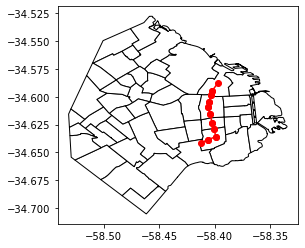

In [85]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
geo_barrios.plot(ax=ax, color='white', edgecolor='black')

for i in range(len(geo_subte_h_geometry)-2): 
    linea_h_geo[i].plot(ax=ax, color='red')

plt.show();